# **Deep Learning Lab: Transfer Learning**

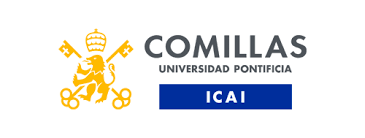

***

In [ ]:
!cat /proc/cpuinfo

cat: /proc/cpuinfo: No such file or directory


In [ ]:
!cat /proc/meminfo

In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!nvidia-smi

In [ ]:
import tensorflow as tf

# Check GPU availability
print("GPU Available:", tf.test.is_gpu_available())

# Check TPU availability
tpu_available = False
devices = tf.config.list_logical_devices()
for device in devices:
    if device.device_type == 'TPU':
        tpu_available = True
        break

print("TPU Available:", tpu_available)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: False
TPU Available: False


In [28]:
from google.colab import drive
drive.mount('/content/drive')

# Navigate to code directory
%cd /content/drive/My Drive/Google Colab/03TransferLearning

# List project directory contents
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: '/content/drive/My Drive/Google Colab/03TransferLearning'
/content
drive  sample_data


## Import packages

In [44]:
from importlib import reload  # Allows reloading user libraries
import sys
sys.path.append('/content/drive/My Drive/deep_learning_lab')
import cnn
from cnn import CNN
import torchvision
from cnn import load_data
from cnn import load_model_weights
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import os
import json

## Model and data loading

In [25]:
# Pytorch has many pre-trained models that can be used for transfer learning
classification_models = torchvision.models.list_models(module=torchvision.models)
print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

In [45]:
# Load data and model
train_dir = '/content/drive/My Drive/deep_learning_lab/dataset/training'
valid_dir = '/content/drive/My Drive/deep_learning_lab/dataset/validation'

train_gon = r'C:\Users\gonza\Desktop\Master\Machine Learning II\5 Deep Learning\dataset\dataset\training'
valid_gon = r'C:\Users\gonza\Desktop\Master\Machine Learning II\5 Deep Learning\dataset\dataset\validation'


train_loader, valid_loader, num_classes = load_data(train_gon,
                                                    valid_gon,
                                                    batch_size=128,
                                                    img_size=224) # ResNet50 requires 224x224 images

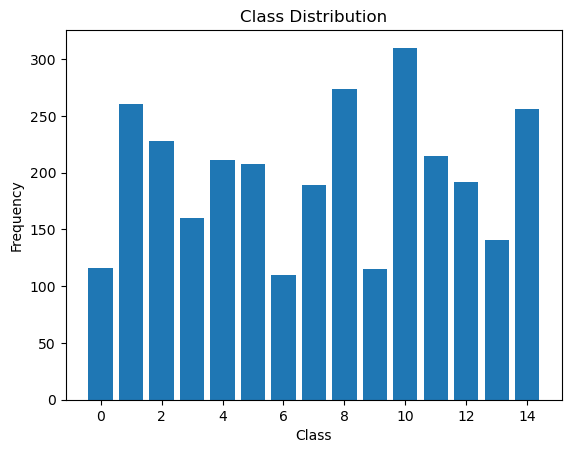

In [27]:
# veo la distribución de las clases
class_distribution = np.zeros(num_classes)
for _, labels in train_loader:
    for label in labels:
        class_distribution[label] += 1

plt.bar(range(num_classes), class_distribution)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution')
plt.show()

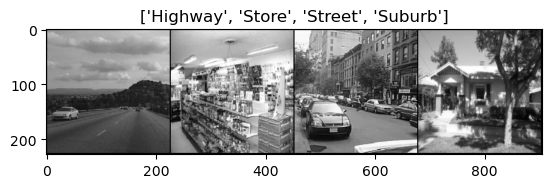

In [28]:
# Visualize a few images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(valid_loader.dataset[i][1])
out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])

Comprobacion de que se está usando GPU

In [46]:
#comprobar que se usa la gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
#mas datos sobre el device cuda
print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 4060 Laptop GPU


## Train

In [47]:
model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes, unfreezed_layers=2)

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min', patience=3, factor=0.1) # Reduce learning rate on plateau, i.e., when the validation loss stops decreasing
criterion = nn.CrossEntropyLoss()
history = model.train_model(train_loader, valid_loader, optimizer, criterion, epochs=30, scheduler=scheduler, patience=6)

Epoch 1/30 - Train Loss: 2.6938, Train Accuracy: 0.2312
Epoch 1/30 - Validation Loss: 2.6794, Validation Accuracy: 0.3720
Epoch 2/30 - Train Loss: 2.6352, Train Accuracy: 0.3863
Epoch 2/30 - Validation Loss: 2.6061, Validation Accuracy: 0.4360
Epoch 3/30 - Train Loss: 2.5191, Train Accuracy: 0.4961
Epoch 3/30 - Validation Loss: 2.4793, Validation Accuracy: 0.5200
Epoch 4/30 - Train Loss: 2.4187, Train Accuracy: 0.5541
Epoch 4/30 - Validation Loss: 2.3769, Validation Accuracy: 0.5687
Epoch 5/30 - Train Loss: 2.3526, Train Accuracy: 0.5977
Epoch 5/30 - Validation Loss: 2.3168, Validation Accuracy: 0.5927
Epoch 6/30 - Train Loss: 2.3091, Train Accuracy: 0.6064
Epoch 6/30 - Validation Loss: 2.2943, Validation Accuracy: 0.5973
Epoch 7/30 - Train Loss: 2.2850, Train Accuracy: 0.6178
Epoch 7/30 - Validation Loss: 2.2731, Validation Accuracy: 0.5967
Epoch 8/30 - Train Loss: 2.2594, Train Accuracy: 0.6291
Epoch 8/30 - Validation Loss: 2.2666, Validation Accuracy: 0.6020
Epoch 9/30 - Train Loss:

learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,▁▃▅▆▇▇▇▇▇▇▇▇████████
train_loss,█▇▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
validation_accuracy,▁▂▄▆▆▆▆▆▆▆▆█████████
validation_loss,█▇▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
learning_rate,0.0001
train_accuracy,0.68744
train_loss,2.16581
validation_accuracy,0.67533
validation_loss,2.16146


c:\Users\gonza\Desktop\Master\Machine Learning II\5 Deep Learning\Trabajo CNN grupal\machine_learning_II_CNN\machine_learning_II_CNN\cnn.py:209: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experi

In [ ]:
model.save_model('resnet50_jaja')

## Predict

#### Load model

In [12]:
# Load model
model_weights = load_model_weights('resnet50_pequeña_mejora')
my_trained_model = CNN(torchvision.models.resnet50(weights='DEFAULT'), num_classes)
my_trained_model.load_state_dict(model_weights)

<All keys matched successfully>

## Results

In [13]:
predicted_labels = my_trained_model.predict(valid_loader)

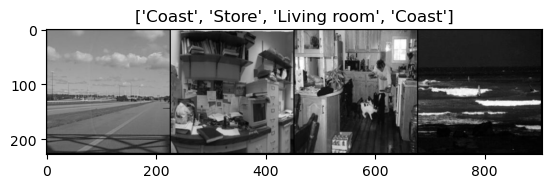

In [14]:
# Get a few random images
random_indices = np.random.choice(len(valid_loader.dataset), size=4, replace=False)
inputs = []
classes = []
for i in random_indices:
    inputs.append(valid_loader.dataset[i][0])
    classes.append(predicted_labels[i])

out = torchvision.utils.make_grid(inputs)
classnames = train_loader.dataset.classes
imshow(out, title=[classnames[x] for x in classes])
